# Packages

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from numpy import array
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Amazon_Products.csv")

data.dropna(subset=['Body'], inplace=True)
data.dropna(subset=['Title'], inplace=True)

data.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ASIN,Product,Title,Rating,Date,Body,Brand
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares


In [3]:
data['Sentiment'] = data['Rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
data['Text'] = data['Body'] + data['Title']
data['id'] = np.arange(data.shape[0])
data.head(5)

,ASIN,Product,Title,Rating,Date,Body,Brand,Sentiment,Text,id
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess,positive,This is a brilliant product...I'd had the Tefa...,0
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess,negative,"I love mine, pity the non stick coating comes ...",1
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess,negative,Thought this product would be great but had it...,2
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares,positive,This is my second one of these the 1st lasted ...,3
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares,positive,Great itemGreat item,4


# EDA

In [4]:
data.isnull().values.any()

False

<Axes: xlabel='Sentiment', ylabel='count'>

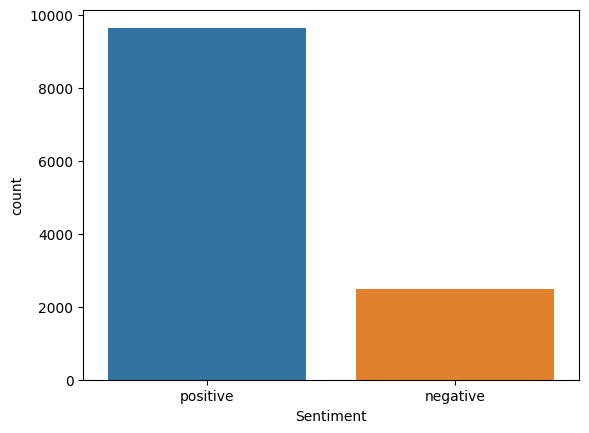

In [5]:
#distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiment', data=data)

# Pre-processing

In [6]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [7]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [8]:
# Calling preprocessing_text function on Amazon_reviews
X = []
sentences = list(data['Text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
y = data['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# Train-Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [11]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [12]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

9136

In [13]:
# Padding all reviews to fixed length 500

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Word Embeddings using GloVe

In [14]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
embedding_matrix.shape

(9136, 100)

# Neural Network architecture

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          913600    
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense (Dense)               (None, 1)                 50001     
                                                                 
Total params: 963,601
Trainable params: 50,001
Non-trainable params: 913,600
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
61/61 [==============================] - 5s 7ms/step - loss: 0.4542 - acc: 0.8126 - val_loss: 0.3784 - val_acc: 0.8303
Epoch 2/6
61/61 [==============================] - 0s 4ms/step - loss: 0.3306 - acc: 0.8658 - val_loss: 0.3276 - val_acc: 0.8695
Epoch 3/6
61/61 [==============================] - 0s 4ms/step - loss: 0.2860 - acc: 0.8910 - val_loss: 0.3026 - val_acc: 0.8762
Epoch 4/6
61/61 [==============================] - 0s 5ms/step - loss: 0.2569 - acc: 0.9038 - val_loss: 0.2882 - val_acc: 0.8871
Epoch 5/6
61/61 [==============================] - 0s 6ms/step - loss: 0.2365 - acc: 0.9145 - val_loss: 0.2761 - val_acc: 0.8922
Epoch 6/6
61/61 [==============================] - 0s 6ms/step - loss: 0.2199 - acc: 0.9252 - val_loss: 0.2675 - val_acc: 0.8979


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 0s 2ms/step - loss: 0.2578 - acc: 0.9088


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2578113377094269
Test Accuracy: 0.9088283777236938


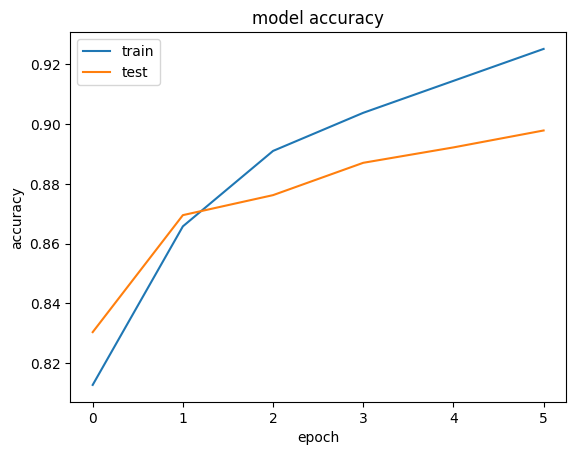

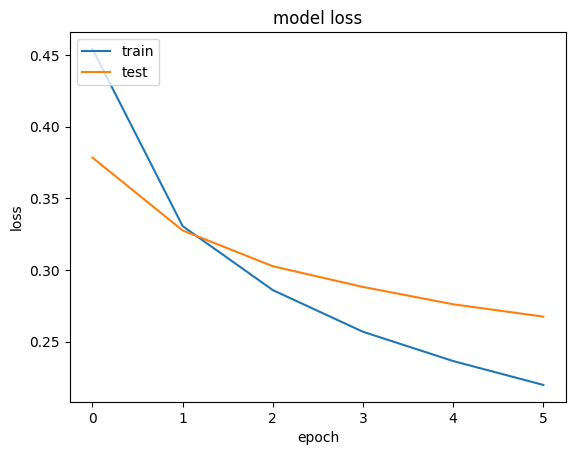

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [17]:
from keras.layers import Conv1D

In [18]:
lr = 1e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.62   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [19]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [20]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          913600    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 977,857
Trainable params: 64,257
Non-trainable params: 913,600
_________________________________________________________________
None


In [21]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=30, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

Epoch 1/40
259/259 [==============================] - 4s 6ms/step - loss: 0.3806 - acc: 0.8291 - val_loss: 0.2371 - val_acc: 0.9242
Epoch 2/40
259/259 [==============================] - 1s 4ms/step - loss: 0.1973 - acc: 0.9337 - val_loss: 0.1762 - val_acc: 0.9433
Epoch 3/40
259/259 [==============================] - 1s 4ms/step - loss: 0.1112 - acc: 0.9759 - val_loss: 0.1783 - val_acc: 0.9443
Epoch 4/40
259/259 [==============================] - 1s 4ms/step - loss: 0.0690 - acc: 0.9884 - val_loss: 0.1409 - val_acc: 0.9510
Epoch 5/40
259/259 [==============================] - 1s 5ms/step - loss: 0.0463 - acc: 0.9933 - val_loss: 0.1488 - val_acc: 0.9536
Epoch 6/40
259/259 [==============================] - 1s 5ms/step - loss: 0.0356 - acc: 0.9954 - val_loss: 0.1438 - val_acc: 0.9489
Epoch 7/40
259/259 [==============================] - 1s 5ms/step - loss: 0.0272 - acc: 0.9957 - val_loss: 0.1506 - val_acc: 0.9458
Epoch 8/40
259/259 [==============================] - 1s 4ms/step - loss: 0.

In [22]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 0s 4ms/step - loss: 0.1269 - acc: 0.9592


In [23]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.1269054412841797
Test Accuracy: 0.9591584205627441


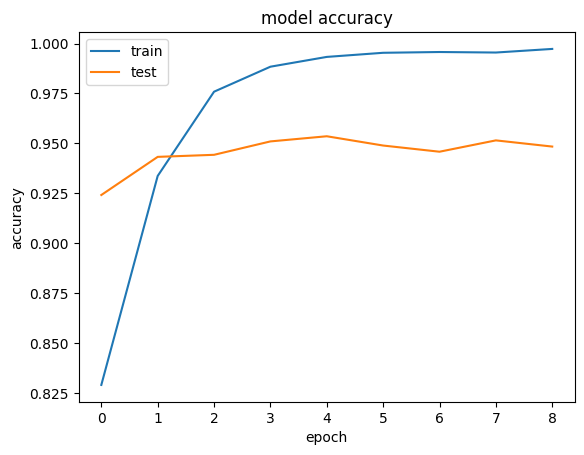

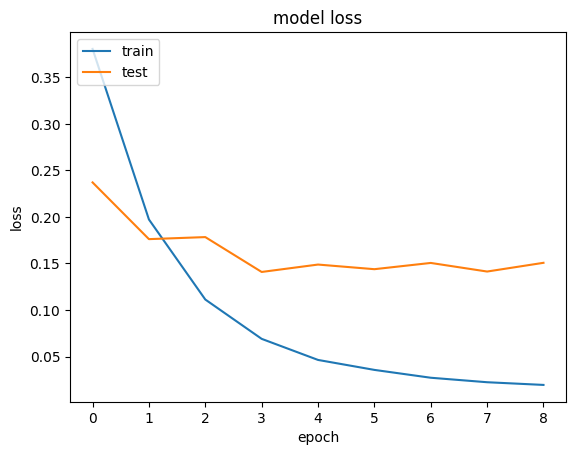

In [24]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
lr = 1e-10
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.62   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          913600    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,030,977
Trainable params: 117,377
Non-trainable params: 913,600
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=30, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

Epoch 1/40
259/259 [==============================] - 6s 21ms/step - loss: 0.6898 - acc: 0.2894 - val_loss: 0.6925 - val_acc: 0.7886
Epoch 2/40
259/259 [==============================] - 6s 22ms/step - loss: 0.6897 - acc: 0.3320 - val_loss: 0.6976 - val_acc: 0.2114
Epoch 3/40
259/259 [==============================] - 6s 21ms/step - loss: 0.6897 - acc: 0.2049 - val_loss: 0.6953 - val_acc: 0.2114
Epoch 4/40
259/259 [==============================] - 5s 21ms/step - loss: 0.6897 - acc: 0.2204 - val_loss: 0.6987 - val_acc: 0.2114
Epoch 5/40
259/259 [==============================] - 6s 22ms/step - loss: 0.6897 - acc: 0.3862 - val_loss: 0.6993 - val_acc: 0.2114
Epoch 6/40
259/259 [==============================] - 5s 21ms/step - loss: 0.6898 - acc: 0.2067 - val_loss: 0.6976 - val_acc: 0.2114
Epoch 6: early stopping


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 1s 10ms/step - loss: 0.6978 - acc: 0.1955


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6978377103805542
Test Accuracy: 0.1955445557832718


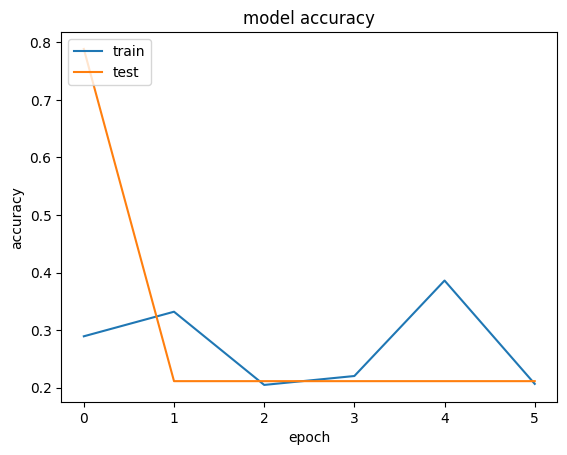

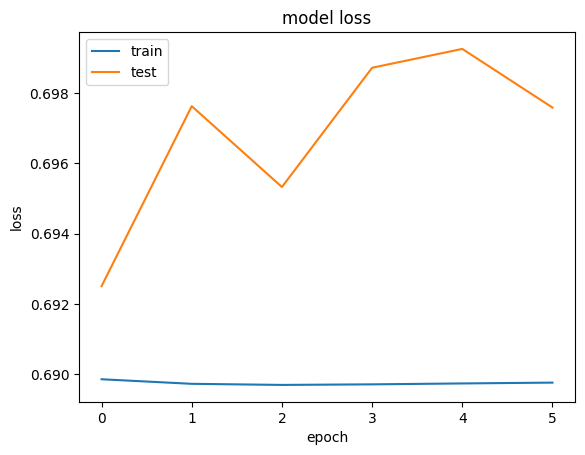

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Testing CNN model on Unseen Dataset

## Without Pre-processing

In [ ]:
# Load sample Amazon reviews csv from kaggle (https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products)

sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews.head(6)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht..."


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['reviews.text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = cnn_model.predict(unseen_padded)

unseen_sentiments

886/886 [==============================] - 2s 2ms/step


array([[0.00198939],
       [0.9672145 ],
       [0.99998987],
       ...,
       [0.99525344],
       [0.93215144],
       [0.9757078 ]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round((unseen_sentiments*10)/2,1)

sample_reviews['Predicted Sentiments']

0        0.0
1        4.8
2        5.0
3        5.0
4        5.0
        ... 
28327    5.0
28328    5.0
28329    5.0
28330    4.7
28331    4.9
Name: Predicted Sentiments, Length: 28332, dtype: float32

In [ ]:
df_cnn_prediction = sample_reviews[['name','reviews.text','reviews.rating','Predicted Sentiments']]

df_cnn_prediction.head(10)

,name,reviews.text,reviews.rating,Predicted Sentiments
0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0
1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.8
2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0
3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0
4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0
5,AmazonBasics AAA Performance Alkaline Batterie...,Bought a lot of batteries for Christmas and th...,5,5.0
6,AmazonBasics AAA Performance Alkaline Batterie...,ive not had any problame with these batteries ...,5,3.7
7,AmazonBasics AAA Performance Alkaline Batterie...,Well if you are looking for cheap non-recharge...,5,5.0
8,AmazonBasics AAA Performance Alkaline Batterie...,These do not hold the amount of high power jui...,3,5.0
9,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AA AAA batteries have done well b...,4,4.7


In [ ]:
df_cnn_prediction.to_csv("./c2_Amazon_Unseen_Predictions.csv", sep=',')


In [ ]:
sample_reviews_1 = pd.read_csv("/content/c2_Amazon_Unseen_Predictions.csv")

sample_reviews_1.head(10)

,Unnamed: 0,name,reviews.text,reviews.rating,Predicted Sentiments
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.8
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0
5,5,AmazonBasics AAA Performance Alkaline Batterie...,Bought a lot of batteries for Christmas and th...,5,5.0
6,6,AmazonBasics AAA Performance Alkaline Batterie...,ive not had any problame with these batteries ...,5,3.7
7,7,AmazonBasics AAA Performance Alkaline Batterie...,Well if you are looking for cheap non-recharge...,5,5.0
8,8,AmazonBasics AAA Performance Alkaline Batterie...,These do not hold the amount of high power jui...,3,5.0
9,9,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AA AAA batteries have done well b...,4,4.7


In [ ]:
df_cnn_prediction['reviews.rating_sentiment'] = df_cnn_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['Predicted.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['cnn_vs_actual'] = df_cnn_prediction['reviews.rating_sentiment'] == df_cnn_prediction['Predicted.rating_sentiment']

df_cnn_prediction.head(10)

,name,reviews.text,reviews.rating,Predicted Sentiments,reviews.rating_sentiment,Predicted.rating_sentiment,cnn_vs_actual
0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0,positive,negative,False
1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.8,positive,positive,True
2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True
3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True
4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True
5,AmazonBasics AAA Performance Alkaline Batterie...,Bought a lot of batteries for Christmas and th...,5,5.0,positive,positive,True
6,AmazonBasics AAA Performance Alkaline Batterie...,ive not had any problame with these batteries ...,5,3.7,positive,positive,True
7,AmazonBasics AAA Performance Alkaline Batterie...,Well if you are looking for cheap non-recharge...,5,5.0,positive,positive,True
8,AmazonBasics AAA Performance Alkaline Batterie...,These do not hold the amount of high power jui...,3,5.0,positive,positive,True
9,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AA AAA batteries have done well b...,4,4.7,positive,positive,True


<Axes: >

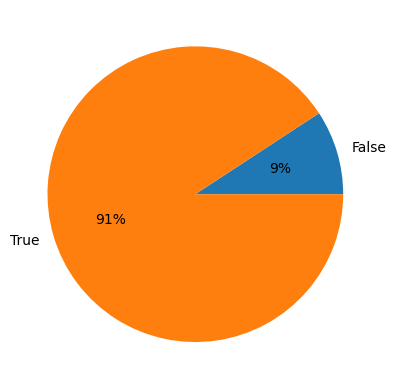

In [ ]:
df_cnn_prediction.groupby('cnn_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

## With Pre-processing

In [ ]:
# Load sample Amazon reviews csv from kaggle (https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products)

sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews.head(6)

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)
	
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence
	

# Calling preprocessing_text function on movie_reviews
mod_sentence = []

sentences = list(sample_reviews['review'])
for sen in sentences:
    mod_sentence.append(preprocess_text(sen))
	
sample_reviews['modified_review'] = pd.Series()

sample_reviews['modified_review'] = mod_sentence

sample_reviews.head(5)

Movie Dataset

In [25]:
# Load sample Amazon reviews csv from kaggle (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

sample_reviews = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

sample_reviews.head(6)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [26]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)
	
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence
	

# Calling preprocessing_text function on movie_reviews
mod_sentence = []

sentences = list(sample_reviews['review'])
for sen in sentences:
    mod_sentence.append(preprocess_text(sen))
	


In [27]:
sample_reviews['modified_review'] = pd.Series()

sample_reviews['modified_review'] = mod_sentence

sample_reviews.head(5)

,review,sentiment,modified_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


In [10]:
from keras.layers import Conv1D

lr = 1e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.62   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))


# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=30, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          9239400   
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None
Epoch 1/40
1067/1067 [==============================] - 14s 5ms/step - loss: 0.4717 - acc: 0.7331 - 

In [28]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['modified_review']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)


# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = cnn_model.predict(unseen_padded)

# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round((unseen_sentiments*10)/2,1)

sample_reviews['Predicted Sentiments']

1563/1563 [==============================] - 3s 2ms/step


0        4.7
1        5.0
2        5.0
3        0.1
4        4.1
        ... 
49995    3.9
49996    0.0
49997    4.3
49998    4.8
49999    1.1
Name: Predicted Sentiments, Length: 50000, dtype: float32

In [30]:
sample_reviews[['review','modified_review','sentiment','Predicted Sentiments']]

,review,modified_review,sentiment,Predicted Sentiments
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode ho...,positive,4.7
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,positive,5.0
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive,5.0
3,Basically there's a family where a little boy ...,basically family little boy jake thinks zombie...,negative,0.1
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...,positive,4.1
...,...,...,...,...
49995,I thought this movie did a down right good job...,thought movie right good job creative original...,positive,3.9
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogue bad acting idiotic direc...,negative,0.0
49997,I am a Catholic taught in parochial elementary...,catholic taught parochial elementary schools n...,negative,4.3
49998,I'm going to have to disagree with the previou...,going disagree previous comment side maltin on...,negative,4.8


In [31]:
df_cnn_prediction = sample_reviews[['review','modified_review','sentiment','Predicted Sentiments']]

#df_cnn_prediction['reviews.rating_sentiment'] = df_cnn_prediction['sentiment'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['Predicted.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['cnn_vs_actual'] = df_cnn_prediction['sentiment'] == df_cnn_prediction['Predicted.rating_sentiment']

df_cnn_prediction.head(10)

,review,modified_review,sentiment,Predicted Sentiments,Predicted.rating_sentiment,cnn_vs_actual
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode ho...,positive,4.7,positive,True
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,positive,5.0,positive,True
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive,5.0,positive,True
3,Basically there's a family where a little boy ...,basically family little boy jake thinks zombie...,negative,0.1,negative,True
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...,positive,4.1,positive,True
5,"Probably my all-time favorite movie, a story o...",probably time favorite movie story selflessnes...,positive,4.8,positive,True
6,I sure would like to see a resurrection of a u...,sure would like see resurrection dated seahunt...,positive,4.6,positive,True
7,"This show was an amazing, fresh & innovative i...",show amazing fresh innovative idea first aired...,negative,0.2,negative,True
8,Encouraged by the positive comments about this...,encouraged positive comments film looking forw...,negative,1.0,negative,True
9,If you like original gut wrenching laughter yo...,like original gut wrenching laughter like movi...,positive,5.0,positive,True


<Axes: >

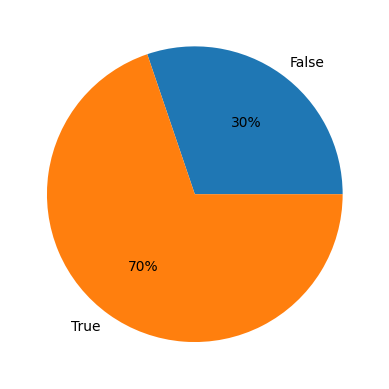

In [32]:
df_cnn_prediction.groupby('cnn_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')